In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=0, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=0, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=0, stride=1)
        self.fc1 = nn.Linear(64 * 3 * 3, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3(x))
        x = x.view(-1, 64 * 3 * 3)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# # Define data augmentation transforms
# train_transform = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

# Define data augmentation transforms
# train_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

# test_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
# transform = transforms.Compose([
#     transforms.ToTensor()
# ])
batch_size = 32
# Load the CIFAR10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


criterion = nn.CrossEntropyLoss()
# criterion = nn.KLDivLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model

def train(net, optimizer, criterion, num_epochs,scheduler=None,criteria="CCE"):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0
        total = 0
        for i, data in enumerate(train_dataloader):
            
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            optimizer.zero_grad()
            outputs = net(inputs)   
            _, preds = torch.max(outputs.data, 1)
            if(criteria == "KL") :
              labels_ = torch.nn.functional.one_hot(labels, num_classes=10) 
              output_ = torch.nn.functional.log_softmax(outputs)
              loss = criterion(output_.float(), labels_.float())
            else : 
              loss = criterion(outputs, labels) #reduction is by default set to mean
            # loss = criterion(outputs, labels) #reduction is by default set to mean
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            total += labels.size(0)
            running_corrects += (preds == labels).sum().item()
            # if i % 100 == 99:
            #     print('[%d, %5d]' % (epoch + 1, i + 1))
            #     # running_loss = 0.0
            # if i % 100 == 99:
            #     print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            #     # running_loss = 0.0
        if scheduler is not None : 
          scheduler.step()
        train_loss.append(running_loss / len(train_dataloader))
        print(f"epoch = {epoch + 1}, loss = {running_loss / len(train_dataloader)}")
        train_acc.append(100 * running_corrects / total)
        print(f"epoch = {epoch + 1}, acc = {100 * running_corrects / total}")
        
        
        # net.eval()
        
        with torch.no_grad():
            running_val_loss = 0.0
            total_val = 0
            correct = 0
            for i, data in enumerate(test_dataloader):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = net(inputs)
                if(criteria == "KL") :
                  labels_ = torch.nn.functional.one_hot(labels, num_classes=10) 
                  output_ = torch.nn.functional.log_softmax(outputs)
                  loss = criterion(output_.float(), labels_.float())
                else : 
                  loss = criterion(outputs, labels) #reduction is by default set to mean
                # loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_val_loss += loss.item()
            val_loss.append(running_val_loss / len(test_dataloader))
            print(f"epoch = {epoch + 1}, loss_val = {running_val_loss / len(test_dataloader)}")
            val_acc.append(100 * correct / total_val)
            print(f"epoch = {epoch + 1}, acc_val = {100 * correct / total_val}")

        # net.train()
    return train_loss, val_loss, train_acc,val_acc





Files already downloaded and verified
Files already downloaded and verified


In [73]:
#  Train the model with Adam optimizer
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import CyclicLR
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import MultiStepLR
net = Net()
optimizer1 = optim.Adam(net.parameters(), lr=0.001)
# optimizer2 = optim.SGD(net.parameters(), lr=0.001)

# scheduler = MultiStepLR(optimizer1, 
#                    milestones = [3, 6,10,17], # Period of learning rate decay
#                    gamma = 0.5)
# scheduler = ExponentialLR(optimizer, gamma=0.9)

# scheduler = CyclicLR(optimizer, 
#                      base_lr = 0.0001, # Initial learning rate which is the lower boundary in the cycle for each parameter group
#                      max_lr = 1e-3, # Upper learning rate boundaries in the cycle for each parameter group
#                      step_size_up = 4, # Number of training iterations in the increasing half of a cycle
#                      mode = "triangular")
# scheduler = ExponentialLR(optimizer1, gamma = 0.5) # Multiplicative factor of learning rate decay.


# Move the model to the GPU device
net.to(device)
# optimizer2 = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train_loss,val_loss,train_acc,val_acc =  train(net, optimizer1, criterion, num_epochs=20,scheduler=None,criteria="CCE")


[1,   100]
[1,   200]
[1,   300]
[1,   400]
[1,   500]
[1,   600]
[1,   700]
[1,   800]
[1,   900]
[1,  1000]
[1,  1100]
[1,  1200]
[1,  1300]
[1,  1400]
[1,  1500]
[2,   100]
[2,   200]
[2,   300]
[2,   400]
[2,   500]
[2,   600]
[2,   700]
[2,   800]
[2,   900]
[2,  1000]
[2,  1100]
[2,  1200]
[2,  1300]
[2,  1400]
[2,  1500]
[3,   100]
[3,   200]
[3,   300]
[3,   400]
[3,   500]
[3,   600]
[3,   700]
[3,   800]
[3,   900]
[3,  1000]
[3,  1100]
[3,  1200]
[3,  1300]
[3,  1400]
[3,  1500]
[4,   100]
[4,   200]
[4,   300]
[4,   400]
[4,   500]
[4,   600]
[4,   700]
[4,   800]
[4,   900]
[4,  1000]
[4,  1100]
[4,  1200]
[4,  1300]
[4,  1400]
[4,  1500]
[5,   100]
[5,   200]
[5,   300]
[5,   400]
[5,   500]
[5,   600]
[5,   700]
[5,   800]
[5,   900]
[5,  1000]
[5,  1100]
[5,  1200]
[5,  1300]
[5,  1400]
[5,  1500]
[6,   100]
[6,   200]
[6,   300]
[6,   400]
[6,   500]
[6,   600]
[6,   700]
[6,   800]
[6,   900]
[6,  1000]
[6,  1100]
[6,  1200]
[6,  1300]
[6,  1400]
[6,  1500]
[7,   100]

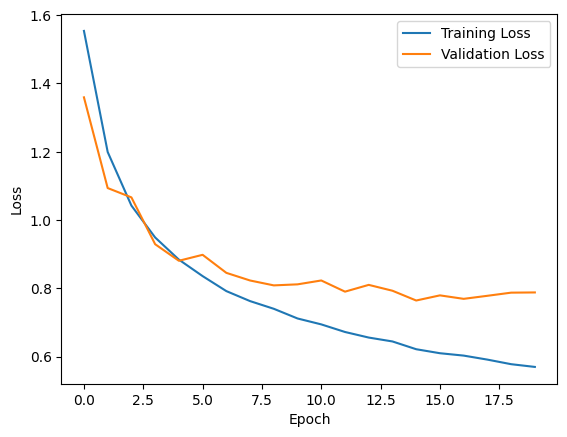

Class-wise accuracy:  [84.4, 89.9, 66.9, 46.5, 70.4, 59.6, 86.7, 79.1, 78.6, 79.1]


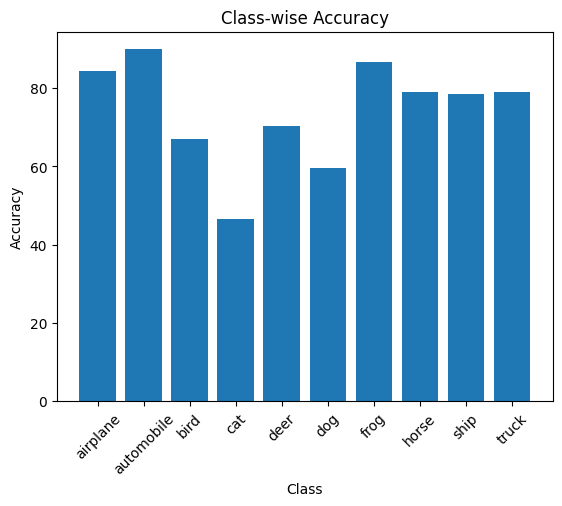

In [74]:

# loss = criterion(nn.functional.log_softmax(outputs, dim=1), nn.functional.softmax(labels, dim=1))
# ptimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = ExponentialLR(optimizer, gamma=0.9)

# for epoch in range(20):
#     for input, target in dataset:
#         optimizer.zero_grad()
#         output = model(input)
#         loss = loss_fn(output, target)
#         loss.backward()
#         optimizer.step()
#     scheduler.step()
# Plot loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Compute final class-wise accuracy
correct = [0] * 10
total = [0] * 10
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            correct[label] += c[i].item()
            total[label] += 1
classwise_accuracy = [100 * correct[i] / total[i] for i in range(10)]
print('Class-wise accuracy: ', classwise_accuracy)

 # Plot class-wise accuracy
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, ax = plt.subplots()
ax.bar(range(10), classwise_accuracy)
ax.set_xticks(range(10))
ax.set_xticklabels(class_names, rotation=45)
ax.set_xlabel('Class')
ax.set_ylabel('Accuracy')
ax.set_title('Class-wise Accuracy')
plt.show()

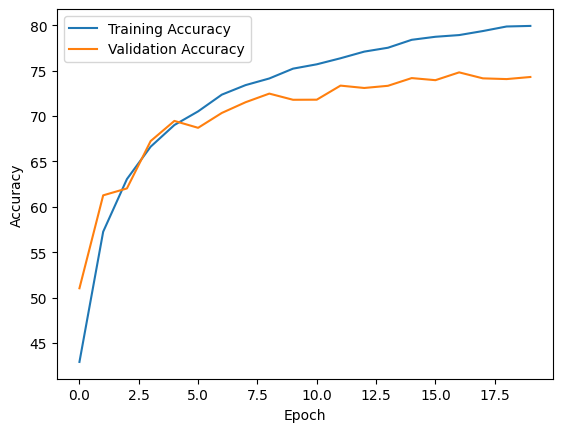

Accuracy of the network on the test images with Adam optimizer: 80 %
Accuracy of the network on the test images with Adam optimizer: 74 %


In [75]:
import matplotlib.pyplot as plt
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

def fin_acc(data_loader) : 
  correct = 0
  total = 0
  with torch.no_grad():
      for data in data_loader:
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = net(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the test images with Adam optimizer: %d %%' % (100 * correct / total))

fin_acc(train_dataloader)
fin_acc(test_dataloader)